## Decision Trees tutorial & improving hosting with skops 🌲

In this notebook I will walk you through decision trees and how to inspect them, and we will later improve model hosting using [skops](https://skops.readthedocs.io/en/stable/). 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install skops

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


We will use breast cancer dataset from sklearn datasets. We will load the dataset and split. 

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [4]:
cancer = load_breast_cancer()
data = pd.DataFrame(cancer.data, columns=[cancer.feature_names])
data.head()

mean radius mean texture mean perimeter mean area mean smoothness  \
0       17.99        10.38         122.80    1001.0         0.11840   
1       20.57        17.77         132.90    1326.0         0.08474   
2       19.69        21.25         130.00    1203.0         0.10960   
3       11.42        20.38          77.58     386.1         0.14250   
4       20.29        14.34         135.10    1297.0         0.10030   

  mean compactness mean concavity mean concave points mean symmetry  \
0          0.27760         0.3001             0.14710        0.2419   
1          0.07864         0.0869             0.07017        0.1812   
2          0.15990         0.1974             0.12790        0.2069   
3          0.28390         0.2414             0.10520        0.2597   
4          0.13280         0.1980             0.10430        0.1809   

  mean fractal dimension  ... worst radius worst texture worst perimeter  \
0                0.07871  ...        25.38         17.33          184.60   
1                0.05667  ...        24.99         23.41          158.80   
2                0.05999  ...        23.57         25.53          152.50   
3                0.09744  ...        14.91         26.50           98.87   
4                0.05883  ...        22.54         16.67          152.20   

  worst area worst smoothness worst compactness worst concavity  \
0     2019.0           0.1622            0.6656          0.7119   
1     1956.0           0.1238            0.1866          0.2416   
2     1709.0           0.1444            0.4245          0.4504   
3      567.7           0.2098            0.8663          0.6869   
4     1575.0           0.1374            0.2050          0.4000   

  worst concave points worst symmetry worst fractal dimension  
0               0.2654         0.4601                 0.11890  
1               0.1860         0.2750                 0.08902  
2               0.2430         0.3613                 0.08758  
3               0.2575         0.6638                 0.17300  
4               0.1625         0.2364                 0.07678  

[5 rows x 30 columns]

In [5]:
X = cancer.data
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    random_state=42)

In [6]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

## Evaluate and Inspect the Model

In [7]:
from sklearn.metrics import classification_report
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92        53
           1       0.96      0.94      0.95        90

    accuracy                           0.94       143
   macro avg       0.93      0.93      0.93       143
weighted avg       0.94      0.94      0.94       143



In [9]:
report = pd.DataFrame.from_dict(classification_report(y_test, y_pred, output_dict = True))

In [10]:
print(report)

                   0          1  accuracy   macro avg  weighted avg
precision   0.907407   0.955056  0.937063    0.931232      0.937396
recall      0.924528   0.944444  0.937063    0.934486      0.937063
f1-score    0.915888   0.949721  0.937063    0.932804      0.937181
support    53.000000  90.000000  0.937063  143.000000    143.000000


In [11]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
                feature_names=cancer.feature_names, impurity=False, filled=True)

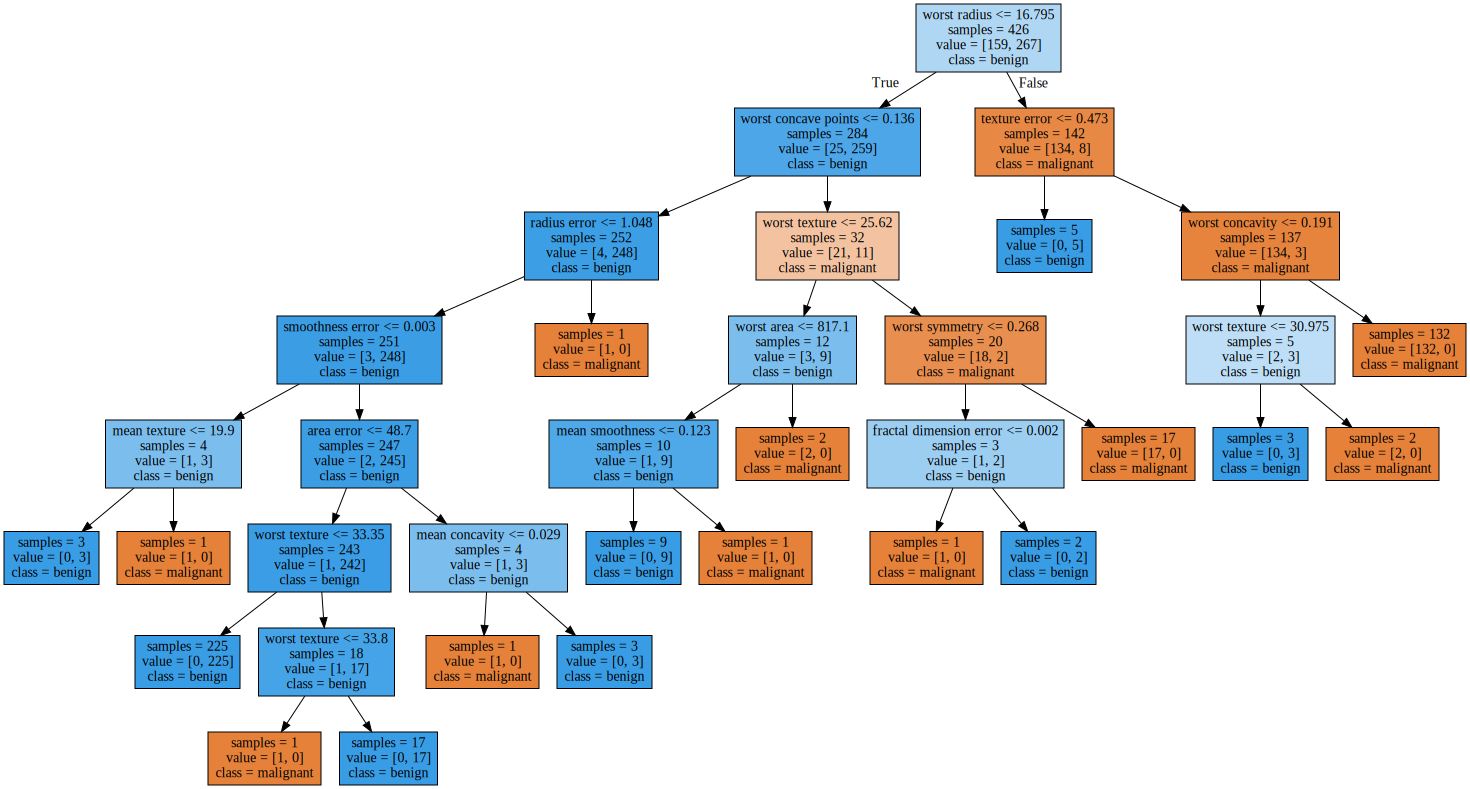

In [12]:
import pydot
import graphviz

(graph,) = pydot.graph_from_dot_file('tree.dot')

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [13]:
print("Feature importances:")
print(tree.feature_importances_)

Feature importances:
[0.         0.00752597 0.         0.         0.00903116 0.
 0.00752597 0.         0.         0.         0.00975731 0.04630969
 0.         0.00238745 0.00231135 0.         0.         0.
 0.         0.00668975 0.69546322 0.05383211 0.         0.01354675
 0.         0.         0.01740312 0.11684357 0.01137258 0.        ]


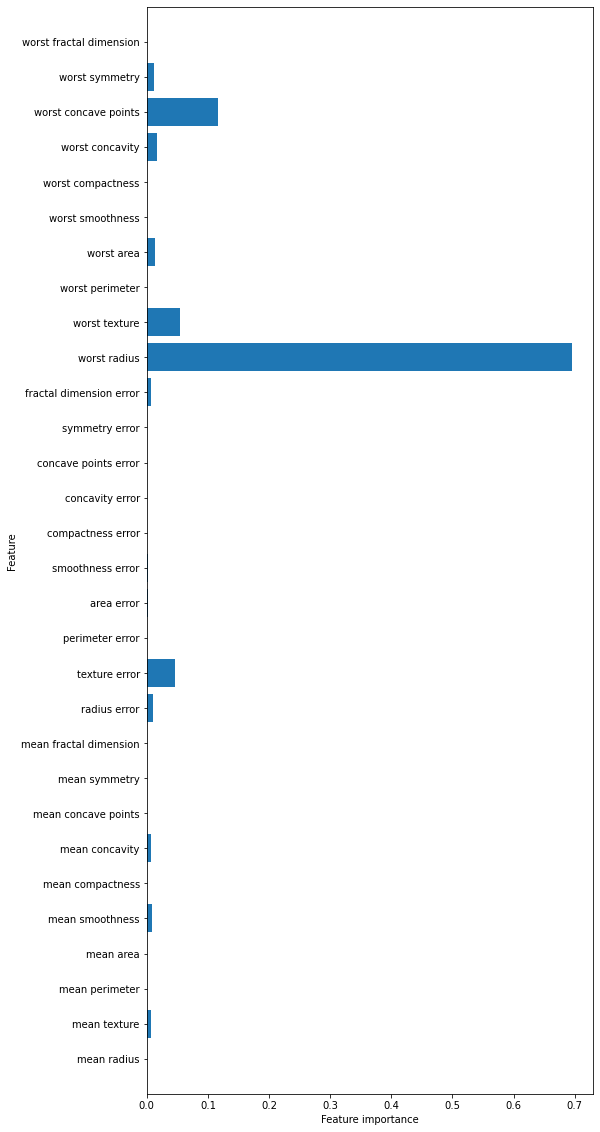

In [14]:
import matplotlib.pyplot as plt
#bar chart of feature importances
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.figure(figsize=(8,20))
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.savefig('testfig.png',dpi=300, bbox_inches = "tight")

plot_feature_importances_cancer(tree)

**We will now apply cost complexity pruning (post-pruning) to our tree to reduce the size and overfitting.**

In [15]:
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [16]:
print(ccp_alphas)

[0.         0.00231936 0.00312989 0.00422535 0.00456509 0.00532081
 0.0056338  0.00633803 0.00814228 0.01487676 0.02166662 0.05466684
 0.32538187]


## Model hosting using skops 🤗
We will now initialize a repository and save a model and a model card in it. 

In [19]:
from skops import hub_utils, card
import os
import joblib

# create a directory to initialize our repo
local_repo = "./model_dir"
# save the model
pkl_path = "./model.pkl"
joblib.dump(tree, pkl_path)

# initialize the repository 
hub_utils.init(model=pkl_path, 
               task="tabular-classification",
               requirements=["scikit-learn"], 
               dst=local_repo,
               data=X_train)

# see what's inside the repository
print(os.listdir(local_repo))

['config.json', 'model.pkl']


We will now initialize a model card and add information.

In [20]:
from pathlib import Path
model_card = card.Card(tree, metadata=card.metadata_from_config(Path(local_repo)))

In [21]:
description = "This is a Decision Tree Classifier trained on breast cancer dataset and pruned with CCP."
limitations = "This model is trained for educational purposes."
model_card.add(model_description = description,
              limitations = limitations)


Card(
  model=DecisionTreeClassifier(random_state=0),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.model_file=model.pkl,
  metadata.widget={...},
  model_description='This is a Decisi...cancer dataset and pruned with CCP.',
  limitations='This model is trained for educational purposes.',
)

We will add the plots we've visualized above.

Card(
  model=DecisionTreeClassifier(random_state=0),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.model_file=model.pkl,
  metadata.widget={...},
  model_description='This is a Decisi...cancer dataset and pruned with CCP.',
  limitations='This model is trained for educational purposes.',
  Feature Importances='feature_importances.png',
  Tree Splits='tree.png',
)

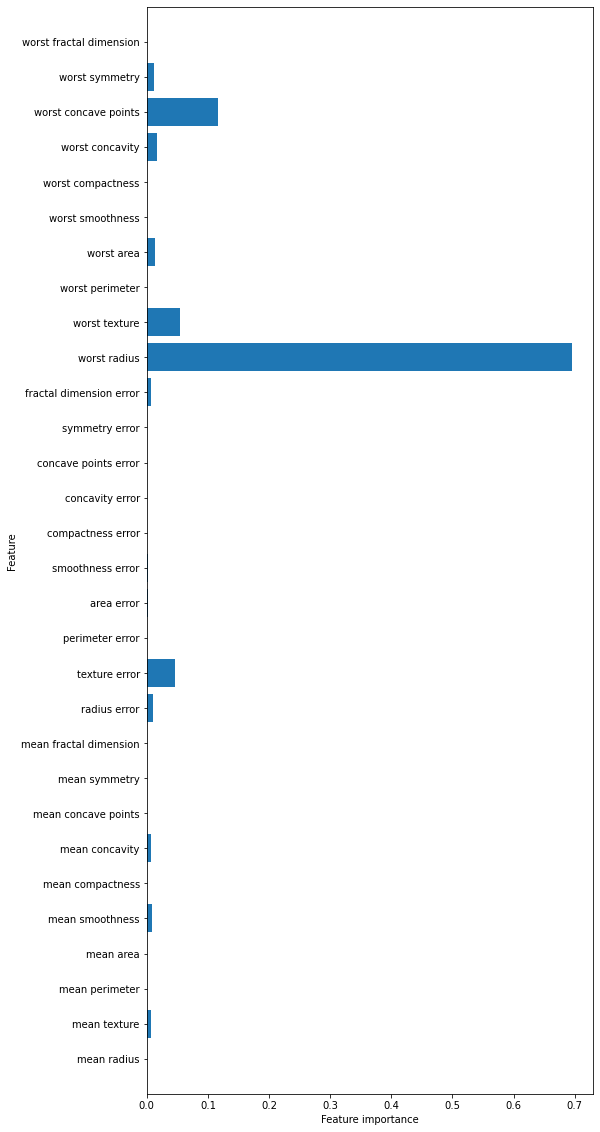

In [22]:
# save feature importance bar chart
plot_feature_importances_cancer(tree)
plt.savefig(Path(local_repo) / 'feature_importances.png')
# save graph
graph.write_png(Path(local_repo) / 'tree.png')

# write the plots to model card
model_card.add_plot(**{"Feature Importances": 'feature_importances.png',
                      "Tree Splits": 'tree.png'})

We can save confusion matrix.

In [23]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
# add metrics to our model card
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="micro")
model_card.add_metrics(**{"accuracy": accuracy, "f1 score": f1})

Card(
  model=DecisionTreeClassifier(random_state=0),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.model_file=model.pkl,
  metadata.widget={...},
  model_description='This is a Decisi...cancer dataset and pruned with CCP.',
  limitations='This model is trained for educational purposes.',
  Feature Importances='feature_importances.png',
  Tree Splits='tree.png',
)

Card(
  model=DecisionTreeClassifier(random_state=0),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.model_file=model.pkl,
  metadata.widget={...},
  model_description='This is a Decisi...cancer dataset and pruned with CCP.',
  limitations='This model is trained for educational purposes.',
  Feature Importances='feature_importances.png',
  Tree Splits='tree.png',
  Confusion Matrix='confusion_matrix.png',
)

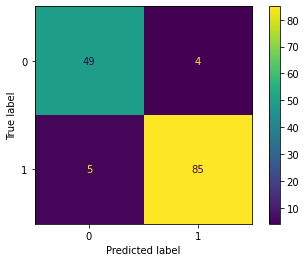

In [24]:
cm = confusion_matrix(y_test, y_pred, labels=tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
disp.plot()
# save the figure to repo
disp.figure_.savefig(Path(local_repo) / "confusion_matrix.png")
# write the figure to model card
model_card.add_plot(**{"Confusion Matrix": "confusion_matrix.png"})

We can now save the model card and push our repository to 🤗Hub!

In [25]:
model_card.save(Path(local_repo) / "README.md")

We will now push the model to 🤗Hub. For this, we firstly need to authenticate ourselves. Then, we can push our model!

In [26]:
from huggingface_hub import notebook_login
notebook_login()

In [27]:
hub_utils.push(repo_id = "scikit-learn/cancer-prediction-trees",
               source = local_repo,
               create_remote = True)